In [187]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from matplotlib import colors as cl
import seaborn as sns
import scipy.stats as sts
import sys
import os

%matplotlib inline


# Load the Data

In [2]:
county_data = pd.read_csv(os.path.realpath("./Data/us_county.csv"))
covid_county_data = pd.read_csv(os.path.realpath("./Data/covid_us_county.csv")).filter(items=["county","state_code","lat","long",
                                                                                                 "date","cases"])
county_pop = pd.read_csv(os.path.realpath("./Data/us_county.csv"))
county_pop = county_pop.sort_values(by="population")

In [3]:
# load in the data
covid_county_data = covid_county_data[(covid_county_data["date"] <= "2020-12-31")]
print(covid_county_data.shape)
covid_county_data.head(5)

(1152990, 6)


,county,state_code,lat,long,date,cases
0,Autauga,AL,32.539527,-86.644082,2020-01-22,0
1,Autauga,AL,32.539527,-86.644082,2020-01-23,0
2,Autauga,AL,32.539527,-86.644082,2020-01-24,0
3,Autauga,AL,32.539527,-86.644082,2020-01-25,0
4,Autauga,AL,32.539527,-86.644082,2020-01-26,0


# Choose 18 random and the minimum and maximum populated counties

In [4]:
np.random.seed(101)

#choose 20 counties to look at, can we find the best parameters for predicting their spread
county_index = list(sts.randint.rvs(low=1,high=county_pop.shape[0]-2,size=19)) + [county_pop.shape[0]-1]
county_index.sort()
counties_to_investigate = county_pop.iloc[county_index,:]
counties_to_investigate

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
261,8033,Dolores County,Colorado,CO,989,852,51.8,1841,46.279196,37.751712,-108.517400
2531,48017,Bailey County,Texas,TX,3640,3452,33.5,7092,48.674563,34.068578,-102.829874
2690,48335,Mitchell County,Texas,TX,5383,3175,34.1,8558,37.099790,32.306202,-100.921138
1569,29173,Ralls County,Missouri,MO,5178,5039,45.0,10217,49.319761,39.527685,-91.522031
1023,21061,Edmonson County,Kentucky,KY,6093,6029,43.8,12122,49.736017,37.208799,-86.238422
398,13023,Bleckley County,Georgia,GA,5937,6838,36.8,12775,53.526419,32.434445,-83.327814
1593,29223,Wayne County,Missouri,MO,6544,6764,47.3,13308,50.826570,37.112647,-90.461405
2133,40005,Atoka County,Oklahoma,OK,7306,6568,40.6,13874,47.340349,34.373729,-96.037824
770,18147,Spencer County,Indiana,IN,10363,10163,43.6,20526,49.512813,38.014096,-87.007670
3040,54097,Upshur County,West Virginia,WV,12200,12405,42.0,24605,50.416582,38.897844,-80.233441


In [27]:
def q_split(cty):
    return str(cty).rsplit()[0]

counties_to_investigate["county"] = counties_to_investigate.county.apply(q_split)
counties_to_investigate.iloc[19,1] = "Los Angeles"

# Join the datasets with population and the COVID-19 Spread

   - Calculate Daily additions for each county
   - Filter out dates before any cases were reported for each county

In [195]:
#first need function to calc diff only if condition met

def ret_bool(cell):
    
    if cell < 0:
        return(0)
    else:
        return(cell)
    
## inner join investigate with daily cases data to filter on counties of interest
counties_filter = counties_to_investigate.merge(covid_county_data,on=["county","state_code"]).iloc[:,[1,2,7,13,14]]
counties_filter["daily_diff"] = [0]+list(np.array(counties_filter.cases[1:counties_filter.shape[0]])-np.array(counties_filter.cases[0:(counties_filter.shape[0]-1)]))

#find the first day with more than 1 case across all cities
cases_temp = pd.Series(counties_filter.sort_values("date").reset_index().cases > 0)
cases_temp = cases_temp[cases_temp].index[0]

#date at that point
date_start = counties_filter.sort_values("date").date.iloc[cases_temp]

#filter from that point on
counties_filter = counties_filter.sort_values("date").reset_index()
counties_filter = counties_filter[counties_filter.date >= date_start]
counties_filter = counties_filter.sort_values(by=["county","date"]).reset_index().iloc[:,[2,3,5,6,7]]

#deal with new cities every once in awhile
counties_filter["daily_diff"] = counties_filter["daily_diff"].apply(ret_bool)

## all counties in dataframe and find the first day that a case was recorded for the chosen county
## will loop over all counties next and produce a visual to see possible fit
all_counties = counties_filter.county.unique()
all_counties

array(['Anson', 'Atoka', 'Bailey', 'Bleckley', 'Cherokee', 'Crawford',
       'Dolores', 'Edmonson', 'Fairfax', 'Gratiot', 'Hardin', 'Logan',
       'Los Angeles', 'Mitchell', 'Morris', 'Ralls', 'Spencer', 'Upshur',
       'Wayne', 'Wicomico'], dtype=object)

# Plot Cumulative cases for each county and the daily case additions

<ipython-input-211-7140ad0e5e2e>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates)


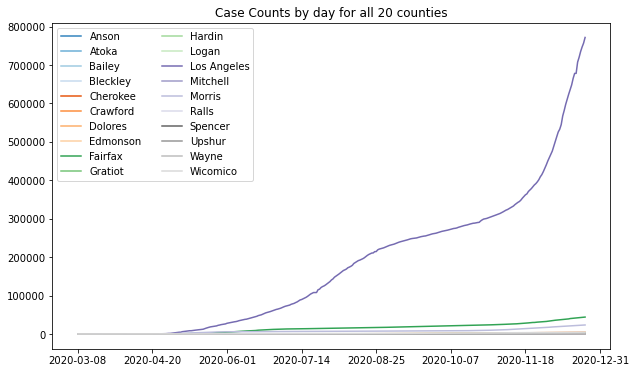

In [211]:
### make some plots, first we can look at the time series of cases for each county

cols = cm.get_cmap("tab20c",20)
cl.rgb2hex(cols(1))
#for each county, filter df and add a line plot. loop through the colormap too to assign colors to each line
#need to creat the ax, fig objects to add the line plots to
#figure(figsize=(10, 6), dpi=80)

fig, ax = plt.subplots(figsize=(10, 6))

index = 0
for c in all_counties:
    
    data = counties_filter[counties_filter.county==c]
    ax.plot(range(0,data.shape[0]),"cases",data=data,c=cl.rgb2hex(cols(index)),label=c)
    index += 1

#case_plot = sns.lineplot(data=counties_filter,hue="county",palette="tab20c",x=range(0,counties_filter.shape[0]),y="cases",
                        #legend=True)

dates = np.array(counties_filter[counties_filter.county=="Anson"].date)[np.linspace(0,340,9).astype(int)]

plt.title("Case Counts by day for all 20 counties")
ax.set_xticklabels(dates)
plt.legend(loc="upper left",ncol=2)

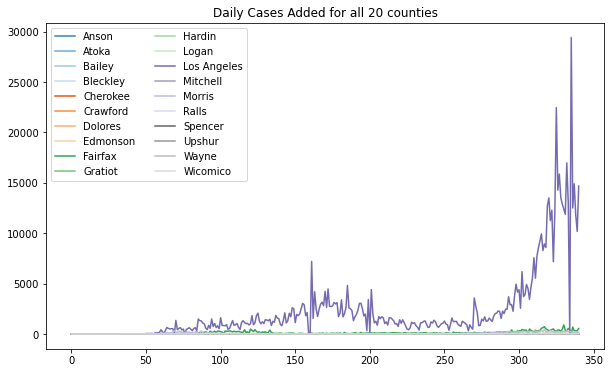

In [212]:
## create ax and figure object and add each dataset to the plot one-by-one.
## index should hopefully be the same for each county

#for each county, filter df and add a line plot. loop through the colormap too to assign colors to each line
#need to creat the ax, fig objects to add the line plots to
#figure(figsize=(10, 6), dpi=80)

fig, ax = plt.subplots(figsize=(10, 6))

index = 0
for c in all_counties:
    
    data = counties_filter[counties_filter.county==c]
    ax.plot(range(0,data.shape[0]),"daily_diff",data=data,c=cl.rgb2hex(cols(index)),label=c)
    index += 1
    
plt.title("Daily Cases Added for all 20 counties")
plt.legend(loc="upper left",ncol=2)



<font size=36> **The simulation** </font>

In [9]:

def branch_sim(params,county,dates,num_days_to_sim=100):
    x0 = 1 # this could change for each county?
    gen = 0 #gen 0 is day 1

    X_n = {} #key is generation (date), value is number from binomial random draw

    #test_df  = counties_filter.iloc[first_case:first_case+num_days_to_sim,:]
    dates_of_sim = dates

    #n, p = (5,.21) #bounding to avoid unwieldy numbers
    #n, p = (5,((4**(1/100))/5)) #bounding to avoid unwieldy numbers
    n, p = params
    all_series = {}
    for runs in range(0,1000):

        for g in range(gen,num_days_to_sim):

            if g == 0:
                X_n[dates_of_sim.iloc[g]] = [x0]
                kids = sum(X_n[dates_of_sim.iloc[g]])

            else:
                #for every parent, generate number of children from binomial
                parents = sum(X_n[dates_of_sim.iloc[g-1]])
                if parents > 0:
                    X_n[dates_of_sim.iloc[g]] = list(sts.binom.rvs(n=n,p=p,size=parents)) #gen children for each parent
                    kids = X_n[dates_of_sim.iloc[g]]
                else:
                    X_n[dates_of_sim.iloc[g]] = [0]

                

        all_series[str(runs+1)] = [sum(tots) for tots in X_n.values()]   #iterate through lists at each gen and sum, store for df     
        X_n = {}

    df_of_sims = pd.DataFrame.from_dict(all_series)
    df_of_sims["Expected_Sim"] = df_of_sims.mean(axis=1)
    df_of_sims.index = dates
    return(df_of_sims)


# Plot the Simulation results

Text(0.5, 1.0, '1000 Simulations of  Binomial Branching Process: $\\mathbf{n=5},\\mathbf{p=.21}$')

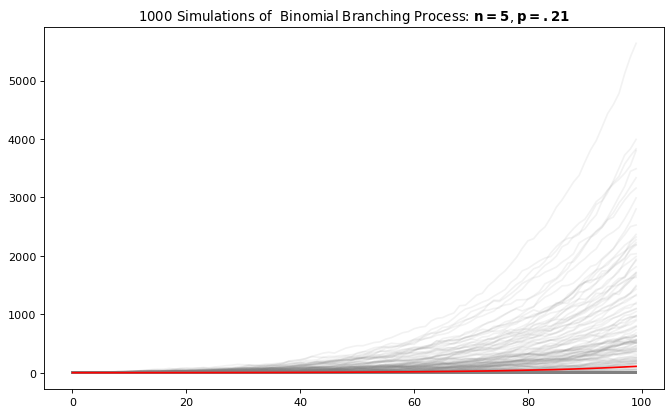

In [11]:
fig = figure(figsize=(10, 6), dpi=80)

ax = fig.add_subplot()

fun_test.loc[:,fun_test.columns != "Expected_Sim"].plot(legend=False,c="gray",alpha=.1,ax=ax)
fun_test.loc[:,fun_test.columns == "Expected_Sim"].plot(legend=False,c="red",alpha=1,ax=ax)
## how to use a variable in the string? str.format or something
plt.title("1000 Simulations of  Binomial Branching Process: $\mathbf{n=5},\mathbf{p=.21}$")

# call the branch sim function for each county and plot the fitted branch sim against the actual daily case counts
   ### - for each county, need number of new cases on day $n$, in order to find the $p$ for the branch sim call
   ### - for each county, find the mean number of cases added (MLE) for the BP
   ### - for each county, find the 7-day average from the last day used to fit the BP

## one plot per county, stats to look at would be the sum of squared residuals and the RMSE of the observations by day


In [12]:
#plotting function for each county

def pplot(df,county,fig):
    
    cols_to_plot = ["Expected_Sim","Expected_Theory","daily_cases"]
    
    df[df.columns.intersection(cols_to_plot)].plot()
    fig.add_subplot()
    plt.title("Fitted Simulation, Theoretical Branching Process Overlaid with\n "+county+" Daily Case Recordings")


In [91]:
## function for iterating through the counties and simulating a branching process then storing the actual spread
## with the expected counts based on the nth day

# branch_sim()
### @param: n,p for binomial distribution
### @param: county name
### @param: number of days to simulate

def county_branch(county,model):
    
    print("Simulating and storing for: "+county)
    num_days_to_sim = 101
    num_days_to_forecast = 30
    
    first_case = pd.Series(counties_filter[counties_filter.county==county].cases > 0)
    first_case = first_case[first_case].index[0]
    
    temp_df = counties_filter.iloc[first_case:first_case+num_days_to_sim,:]
    dates_of_sim = temp_df.date
    
    temp_forecast = counties_filter.iloc[first_case:first_case+num_days_to_sim+num_days_to_forecast,:]
    
    ## find p
    n = 5
    if model == "nth day":
        #mu based on 100th day cases, what if i took average cases instead
        print("County: "+str(temp_df.iloc[100,4]))
        mu = temp_df.iloc[100,4]**(1/num_days_to_sim)
        p = mu / n
    elif model == "sample average":
        mu = np.mean(temp_df.daily_diff)**(1/num_days_to_sim)
        p = mu / n
    else:
        mu = np.mean(temp_df.daily_diff[num_days_to_sim-7:])**(1/num_days_to_sim)
        p = mu / n
    
    params = (n,p)
    
    forecast_df = counties_filter.iloc[first_case:first_case+num_days_to_sim+num_days_to_forecast,:]
    forecast_df["Expected_Theory"] = np.array([1]+[mu**n for n in range(1,num_days_to_sim+num_days_to_forecast)])
    forecast_df["Sq_Er"] = (forecast_df.Expected_Theory - forecast_df.daily_diff)**2
    forecast_df.index = np.array(range(0,num_days_to_sim+num_days_to_forecast))
    
    county_df = branch_sim(params=params,county=county,dates=dates_of_sim,num_days_to_sim=num_days_to_sim)
    county_df["daily_cases"] = temp_df.daily_diff.values #add daily counts to end for plotting
    county_df["Expected_Theory"] = np.array([1]+[mu**n for n in range(1,num_days_to_sim)])
    county_df["Sq_Er"] = (county_df.Expected_Theory - county_df.daily_cases)**2
    county_df.index = dates_of_sim

    county_RMSE = np.sqrt(np.sum(county_df.Sq_Er)/num_days_to_sim)
    return((county_df,forecast_df,mu,county_RMSE))

## call for each county and produce a plot with the branching sim and the
## actual daily differences for the paper

##### need to store the outputs, and the expected value of the distribution for each.
######### will use the expected value to predict into the future
############### this number would be an anticipated case additions if no preventative measures are put into place

output_analyze_nth = {}
output_analyze_mean = {}
output_analyze_seven = {}

for county in all_counties:
    
    # store the data frame, mu for that county
    output_analyze_nth[county] = county_branch(county,model="nth day")
    output_analyze_mean[county] = county_branch(county,model="sample average")
    output_analyze_seven[county] = county_branch(county,model="seven")

Simulating and storing for: Anson
County: 5
Simulating and storing for: Anson
Simulating and storing for: Anson
Simulating and storing for: Atoka
County: 0
Simulating and storing for: Atoka
Simulating and storing for: Atoka
Simulating and storing for: Bailey
County: 1
Simulating and storing for: Bailey
Simulating and storing for: Bailey
Simulating and storing for: Bleckley
County: 0
Simulating and storing for: Bleckley
Simulating and storing for: Bleckley
Simulating and storing for: Cherokee
County: 0
Simulating and storing for: Cherokee
Simulating and storing for: Cherokee
Simulating and storing for: Crawford
County: 7
Simulating and storing for: Crawford
Simulating and storing for: Crawford
Simulating and storing for: Dolores
County: 0
Simulating and storing for: Dolores
Simulating and storing for: Dolores
Simulating and storing for: Edmonson
County: 0
Simulating and storing for: Edmonson
Simulating and storing for: Edmonson
Simulating and storing for: Fairfax
County: 11
Simulating a

# Plot the fits for the 3 models across each county

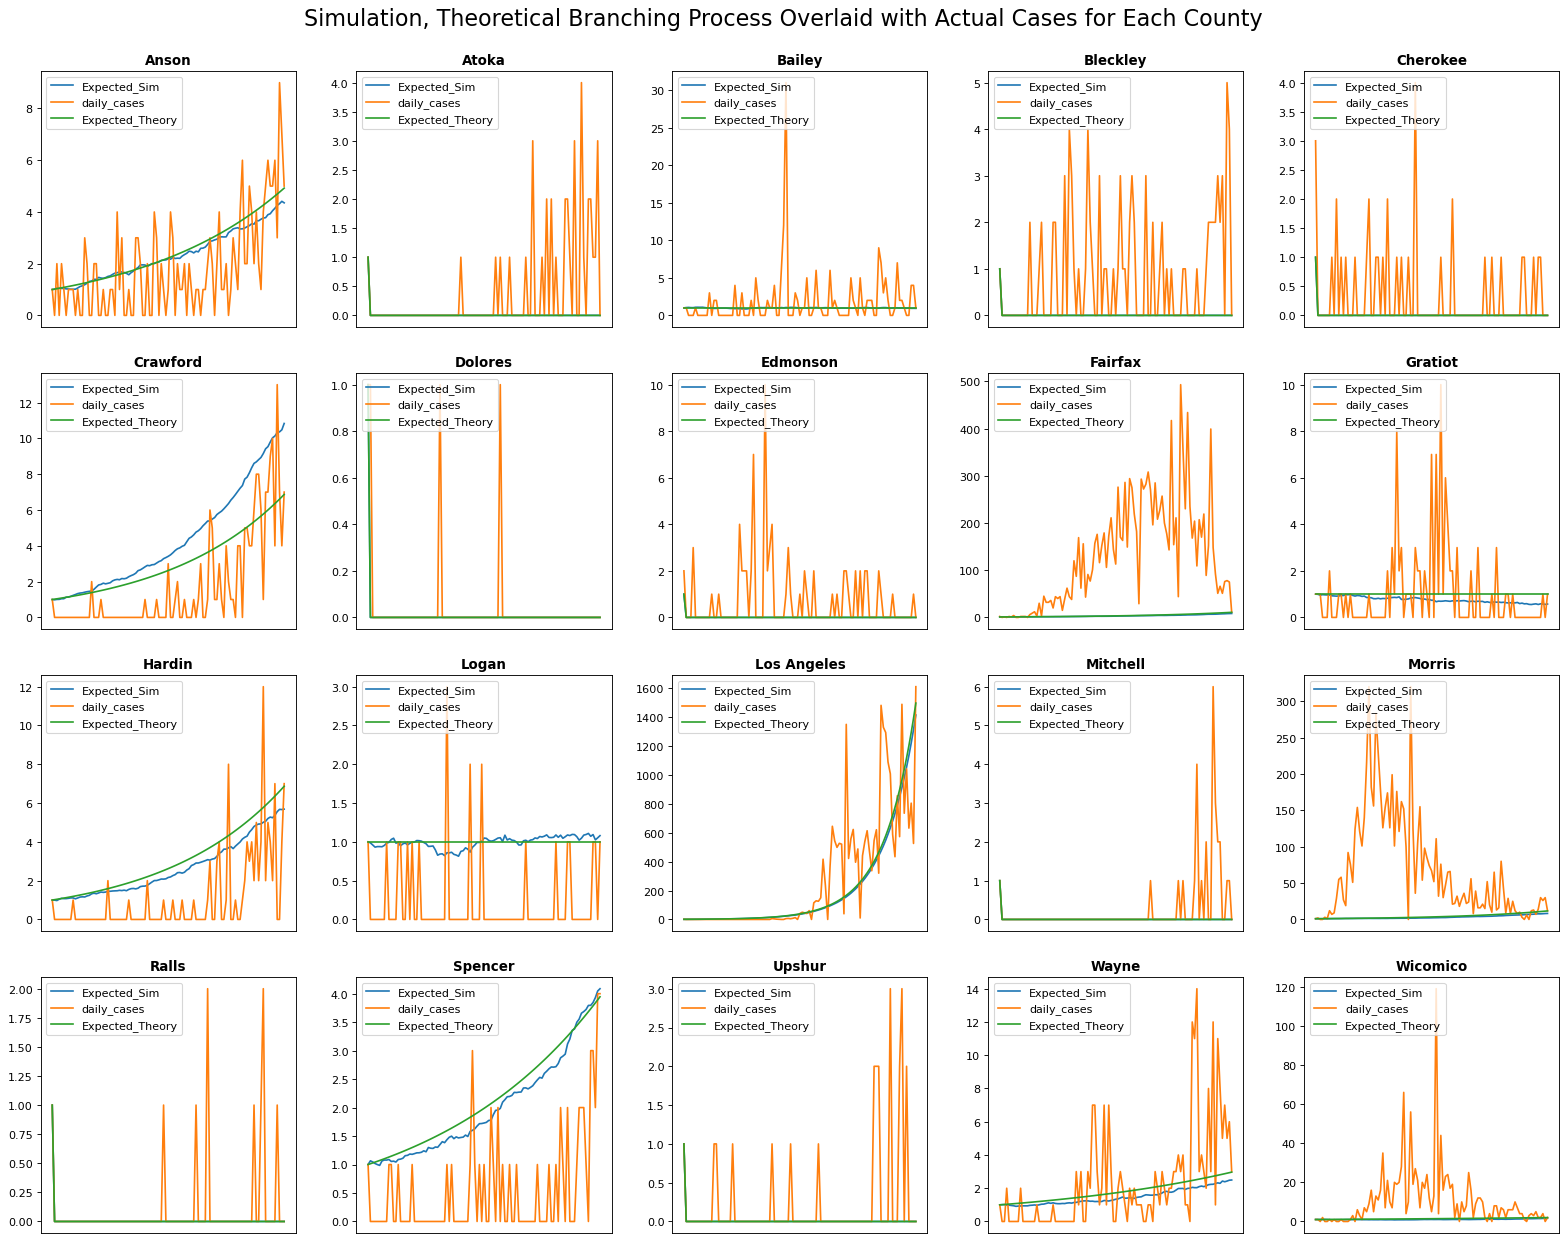

In [111]:
## calculate RMSE for training set, then try to predict n+1,n+2,n+...,n+30 days into future. 

def plot_fits(dct,predict):
    
    if not predict:
        index = 1
        fig = figure(figsize=(20, 16), dpi=80)
        cols_to_plot = ["Expected_Sim","Expected_Theory","daily_cases"]

        for c, data in dct.items():

            df = data[0]
            ax = fig.add_subplot(4,5,index)
            index += 1

            fig.suptitle("Simulation, Theoretical Branching Process Overlaid with Actual Cases for Each County",fontsize=20)
            df[df.columns.intersection(cols_to_plot)].plot(ax=ax)
            plt.title(c,fontsize="large",fontweight="bold")
            plt.legend(loc="upper left")
            plt.xticks([])
            plt.xlabel("")
    else:
        index = 1
        fig = figure(figsize=(20, 16), dpi=80)
        cols_to_plot = ["Expected_Theory","daily_cases"]
        
        for c, data in dct.items():

            df = data[1]
            ax = fig.add_subplot(4,5,index)
            index += 1

            fig.suptitle("Predicting 30 days into the future with the Underlying Branching Process Model\n $\mu_{county}= MLE\ for\ p\ in\ Binomial\ Branching\ Process$",fontsize=20)
            #df[df.columns.intersection(cols_to_plot)].plot(ax=ax)
            df.loc[df.index < 100,"Expected_Theory"].plot(ax=ax,c="green")
            df.loc[df.index >= 100,"Expected_Theory"].plot(ax=ax,c="red")
            df.loc[:,"daily_diff"].plot(ax=ax,c="orange")
            plt.title(c,fontsize="large",fontweight="bold")
            plt.legend(loc="upper left")
            plt.xticks([])
            plt.xlabel("")
    plt.tight_layout(pad=2.2)

## add RMSE for each county to the stored dictionary
plot_fits(output_analyze_nth,predict=False)

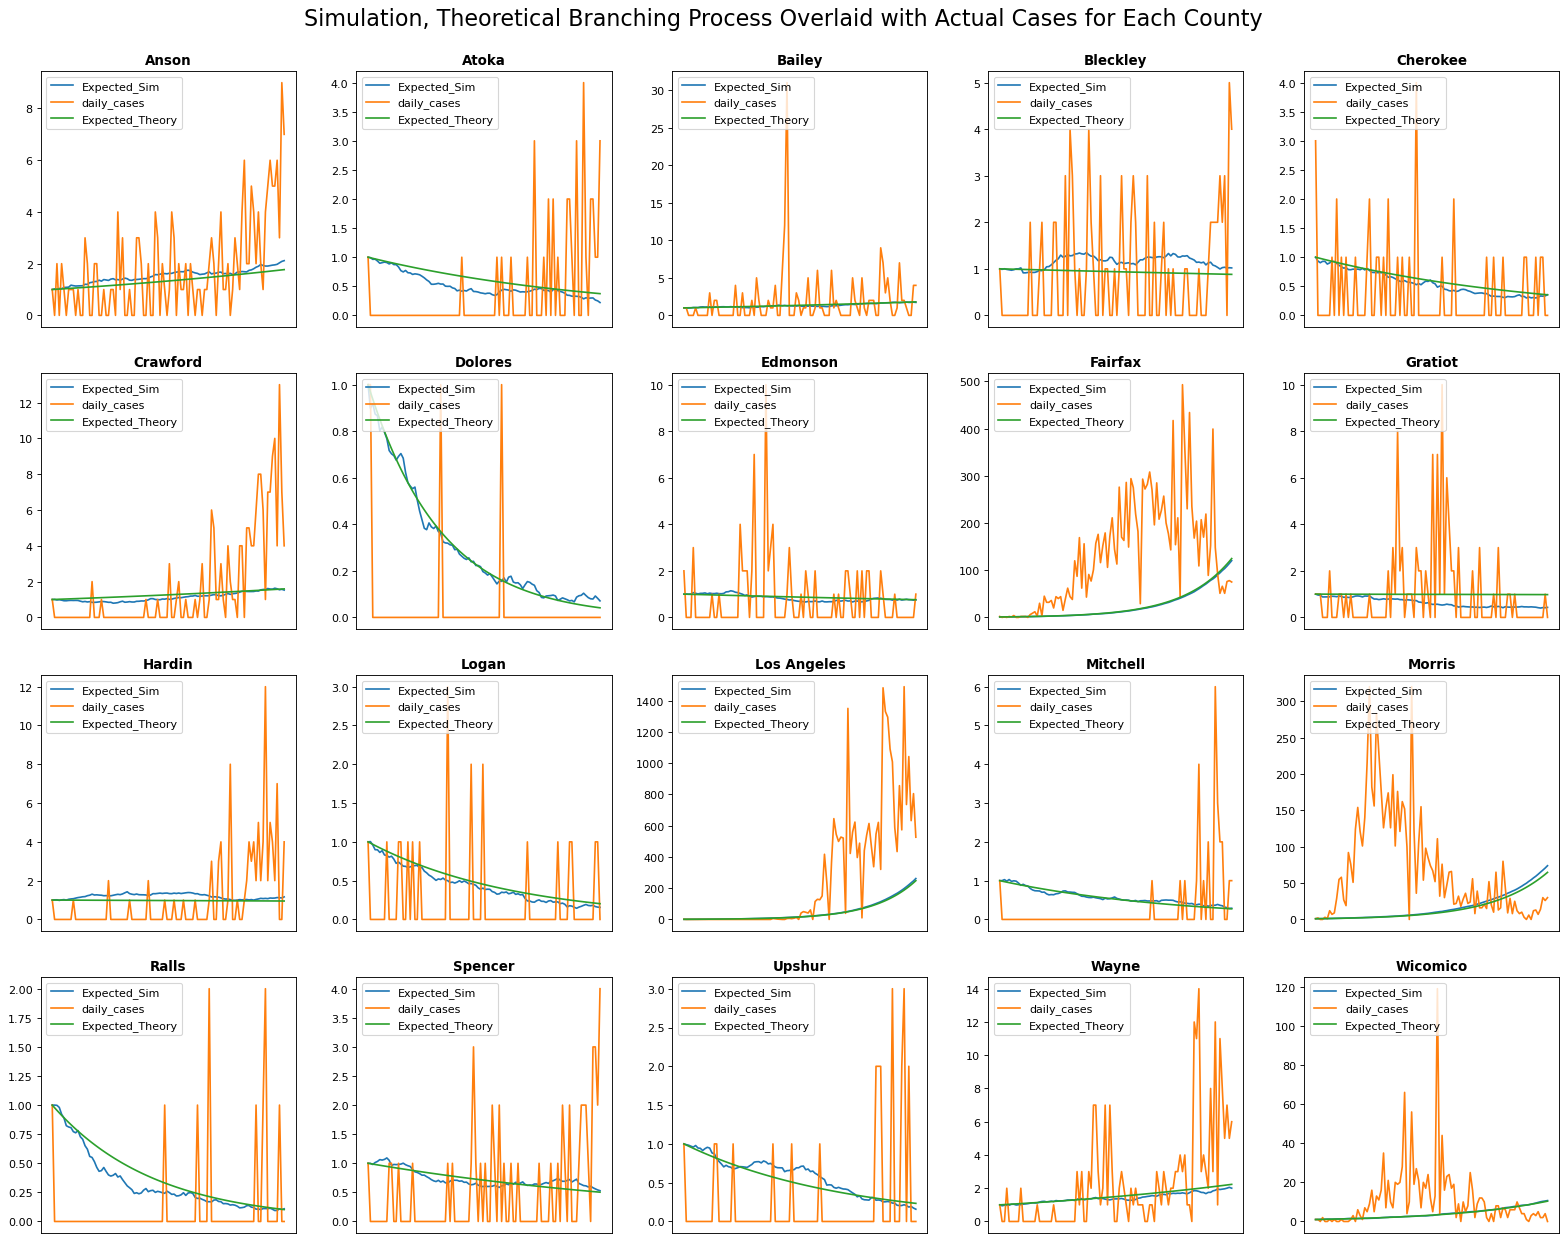

In [17]:
plot_fits(output_analyze_mean)

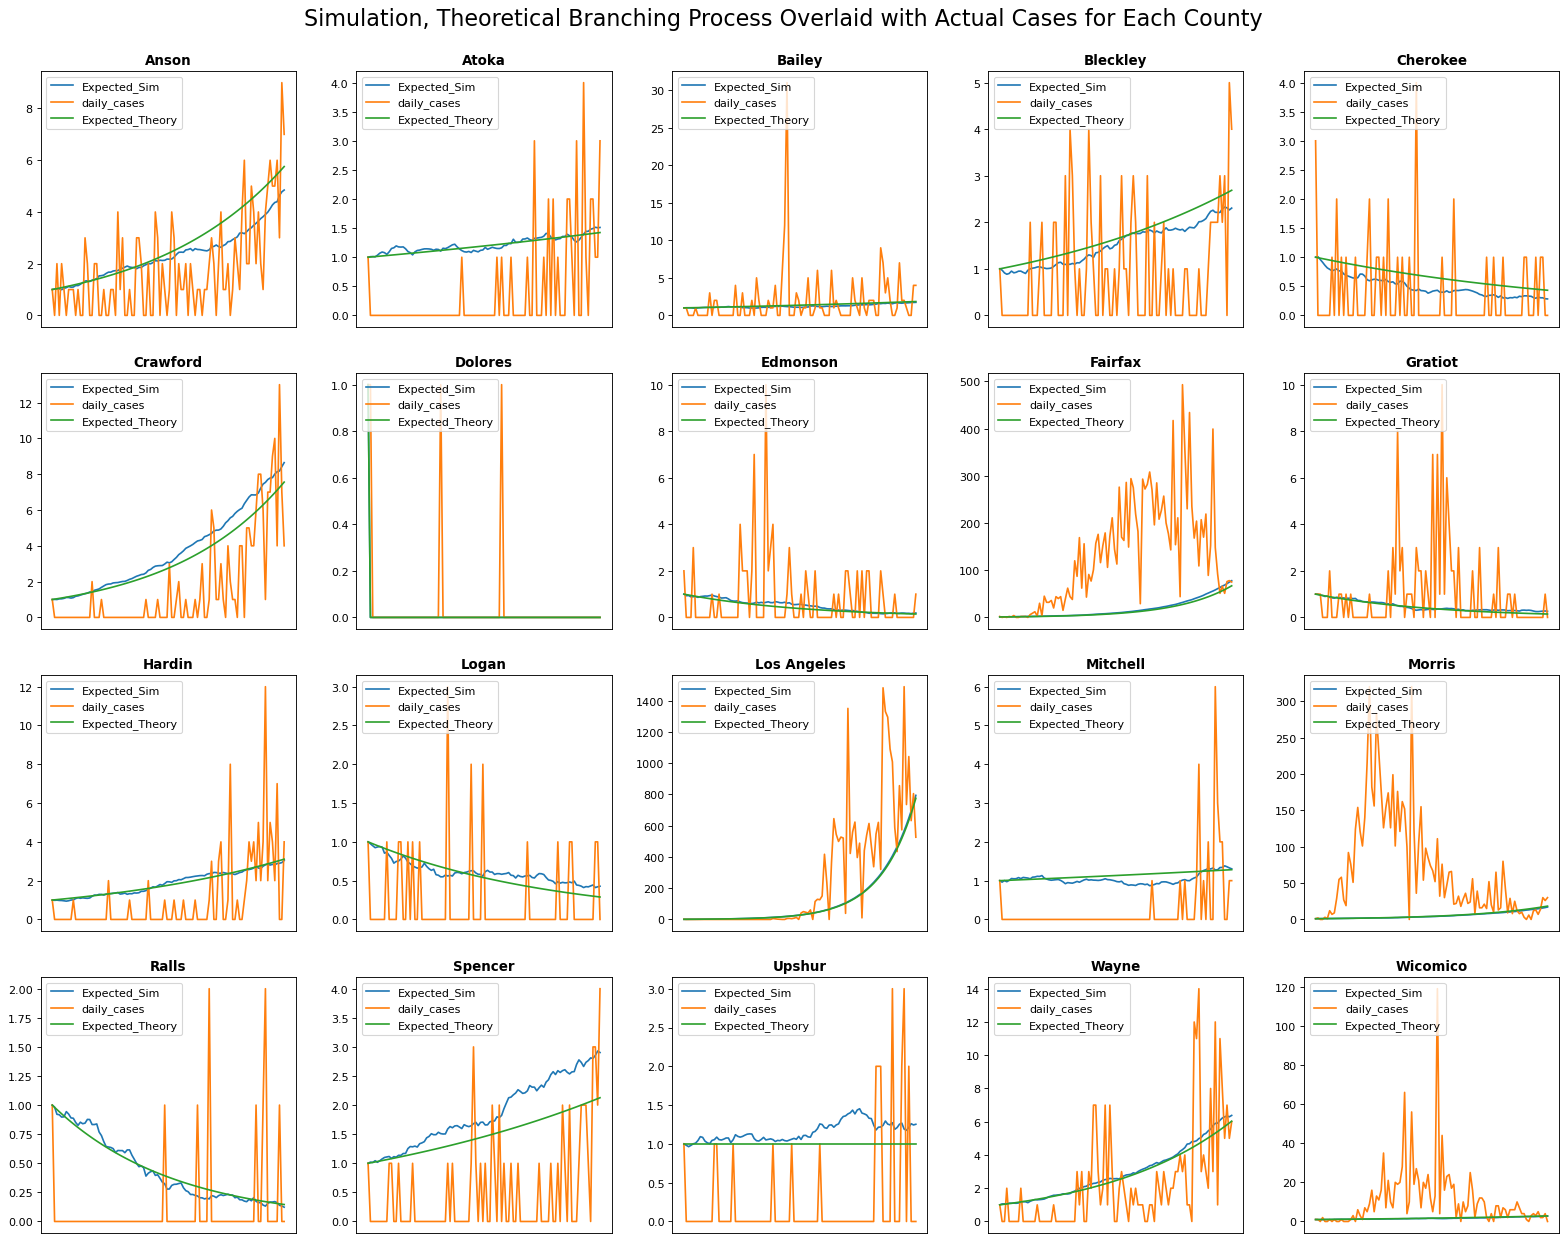

In [18]:
plot_fits(output_analyze_seven)

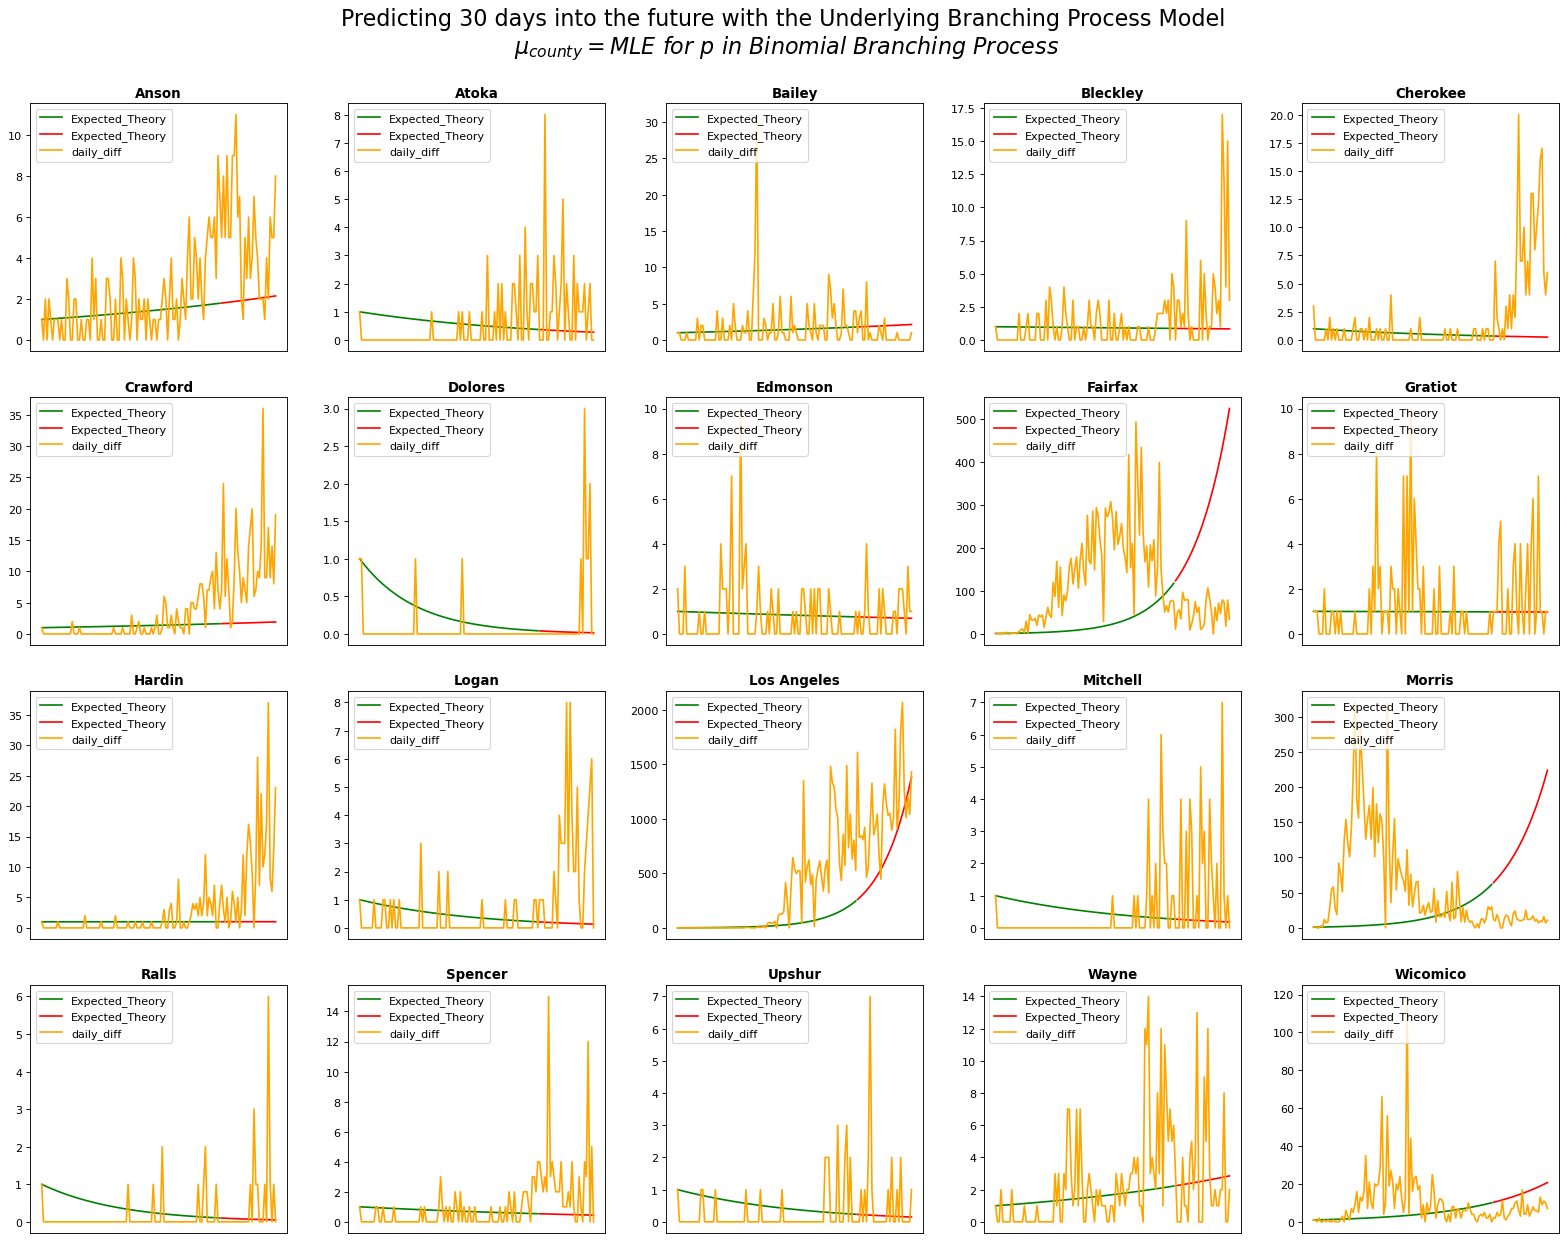

In [112]:
plot_fits(output_analyze_mean,predict=True)

# Calculate the RMSE for each model after fitting and predicting

In [76]:
output_analyze_nth["Anson"][1].tail(5)

,county,state,date,cases,daily_diff,Expected_Theory,Sq_Er
125,Anson,North Carolina,2020-08-03,308,4,11.386036,54.553527
126,Anson,North Carolina,2020-08-04,310,2,11.609768,92.347635
127,Anson,North Carolina,2020-08-05,316,6,11.837896,34.081027
128,Anson,North Carolina,2020-08-06,321,5,12.070506,49.992061
129,Anson,North Carolina,2020-08-07,326,5,12.307688,53.402301


In [110]:
## going to plot 1 of the models with predicitions.

#after that will summarize with RMSE for all models and every county

def calc_rmse(dct):
    
    #store RMSE for df
    rmse = {}
    
    #create df with cols being RMSE for each model type and rows are the county
    
    for c, value in dct.items():
        
        rmse[c] = np.sqrt(sum(value[1].tail(30).Sq_Er))
    
    return(rmse)
    
nth_rmse = calc_rmse(output_analyze_nth)   
mean_rmse = calc_rmse(output_analyze_mean)
seven_rmse = calc_rmse(output_analyze_seven)

nth_rmse = pd.DataFrame.from_dict(nth_rmse,orient="index")
mean_rmse = pd.DataFrame.from_dict( mean_rmse,orient="index")
seven_rmse = pd.DataFrame.from_dict(seven_rmse,orient="index")

all_rmse = nth_rmse.join(mean_rmse.join(seven_rmse,rsuffix="seven"),rsuffix="mean")
all_rmse.columns = ["nth_rmse","MLE_rmse","seven_rmse"]

def highlight_min(x, color):
    return np.where(x == np.nanmin(x.to_numpy()), f"color: {color};", None)
all_rmse.style.apply(highlight_min,color="green",axis=1)


,nth_rmse,MLE_rmse,seven_rmse
Anson,18.164562,22.092220,21.807663
Atoka,11.789826,10.804891,9.427676
Bailey,9.380832,11.479057,11.130030
Bleckley,30.248967,27.604929,23.493957
Cherokee,46.270941,45.051350,44.708820
Crawford,39.658073,66.226406,38.257778
Dolores,4.000000,3.966754,4.000000
Edmonson,7.348469,5.682933,6.990172
Fairfax,257.452194,1426.873389,411.677448
Gratiot,11.747340,11.794476,13.855355


# New fits with time series methods


In [154]:


def time_series(county,method):
    
    print("Simulating and storing for: "+county)
    num_days_to_sim = 100
    num_days_to_forecast = 30
    
    first_case = pd.Series(counties_filter[counties_filter.county==county].cases > 0)
    first_case = first_case[first_case].index[0]
    
    county_df = counties_filter.iloc[first_case:first_case+num_days_to_sim+num_days_to_forecast,:]
    dates_of_sim = county_df.date
    
    if method == "mean": #predict that new cases will be mean of training data
        county_df["Predict"] = np.concatenate((np.array(county_df.daily_diff[:100]),np.repeat(np.mean(county_df.daily_diff[:100]),num_days_to_forecast)))
        county_df["Sq_Er"] = (county_df.Predict - county_df.daily_diff)**2

    elif method == "naive": #predict that new cases will be last observed value of training data
        county_df["Predict"] = np.concatenate((np.array(county_df.daily_diff[:100]),np.repeat(county_df.daily_diff.iloc[100],num_days_to_forecast)))
        county_df["Sq_Er"] = (county_df.Predict - county_df.daily_diff)**2
 
    else: #predict that new cases will be linear following the difference in last observation and first
        drift = county_df.daily_diff.iloc[100] - county_df.daily_diff.iloc[0]
        drift_pred = drift * np.linspace(1,30,num=30)
        county_df["Predict"] = np.concatenate((np.array(county_df.daily_diff[:100]),drift_pred))
        county_df["Sq_Er"] = (county_df.Predict - county_df.daily_diff)**2
        
    county_df.index = np.array(range(0,num_days_to_sim+num_days_to_forecast))    
    return(county_df)    
        
        
        
        

np.mean(anson.daily_cases)

In [155]:
time_out_mean = {}
time_out_naive = {}
time_out_drift = {}

for c in all_counties:
    
    time_out_mean[c] = time_series(c,"mean")
    time_out_naive[c] = time_series(c,"naive")
    time_out_drift[c] = time_series(c,"drift")

Simulating and storing for: Anson
Simulating and storing for: Anson
Simulating and storing for: Anson
Simulating and storing for: Atoka
Simulating and storing for: Atoka
Simulating and storing for: Atoka
Simulating and storing for: Bailey
Simulating and storing for: Bailey
Simulating and storing for: Bailey
Simulating and storing for: Bleckley
Simulating and storing for: Bleckley
Simulating and storing for: Bleckley
Simulating and storing for: Cherokee
Simulating and storing for: Cherokee
Simulating and storing for: Cherokee
Simulating and storing for: Crawford
Simulating and storing for: Crawford
Simulating and storing for: Crawford
Simulating and storing for: Dolores
Simulating and storing for: Dolores
Simulating and storing for: Dolores
Simulating and storing for: Edmonson
Simulating and storing for: Edmonson
Simulating and storing for: Edmonson
Simulating and storing for: Fairfax
Simulating and storing for: Fairfax
Simulating and storing for: Fairfax
Simulating and storing for: Gra

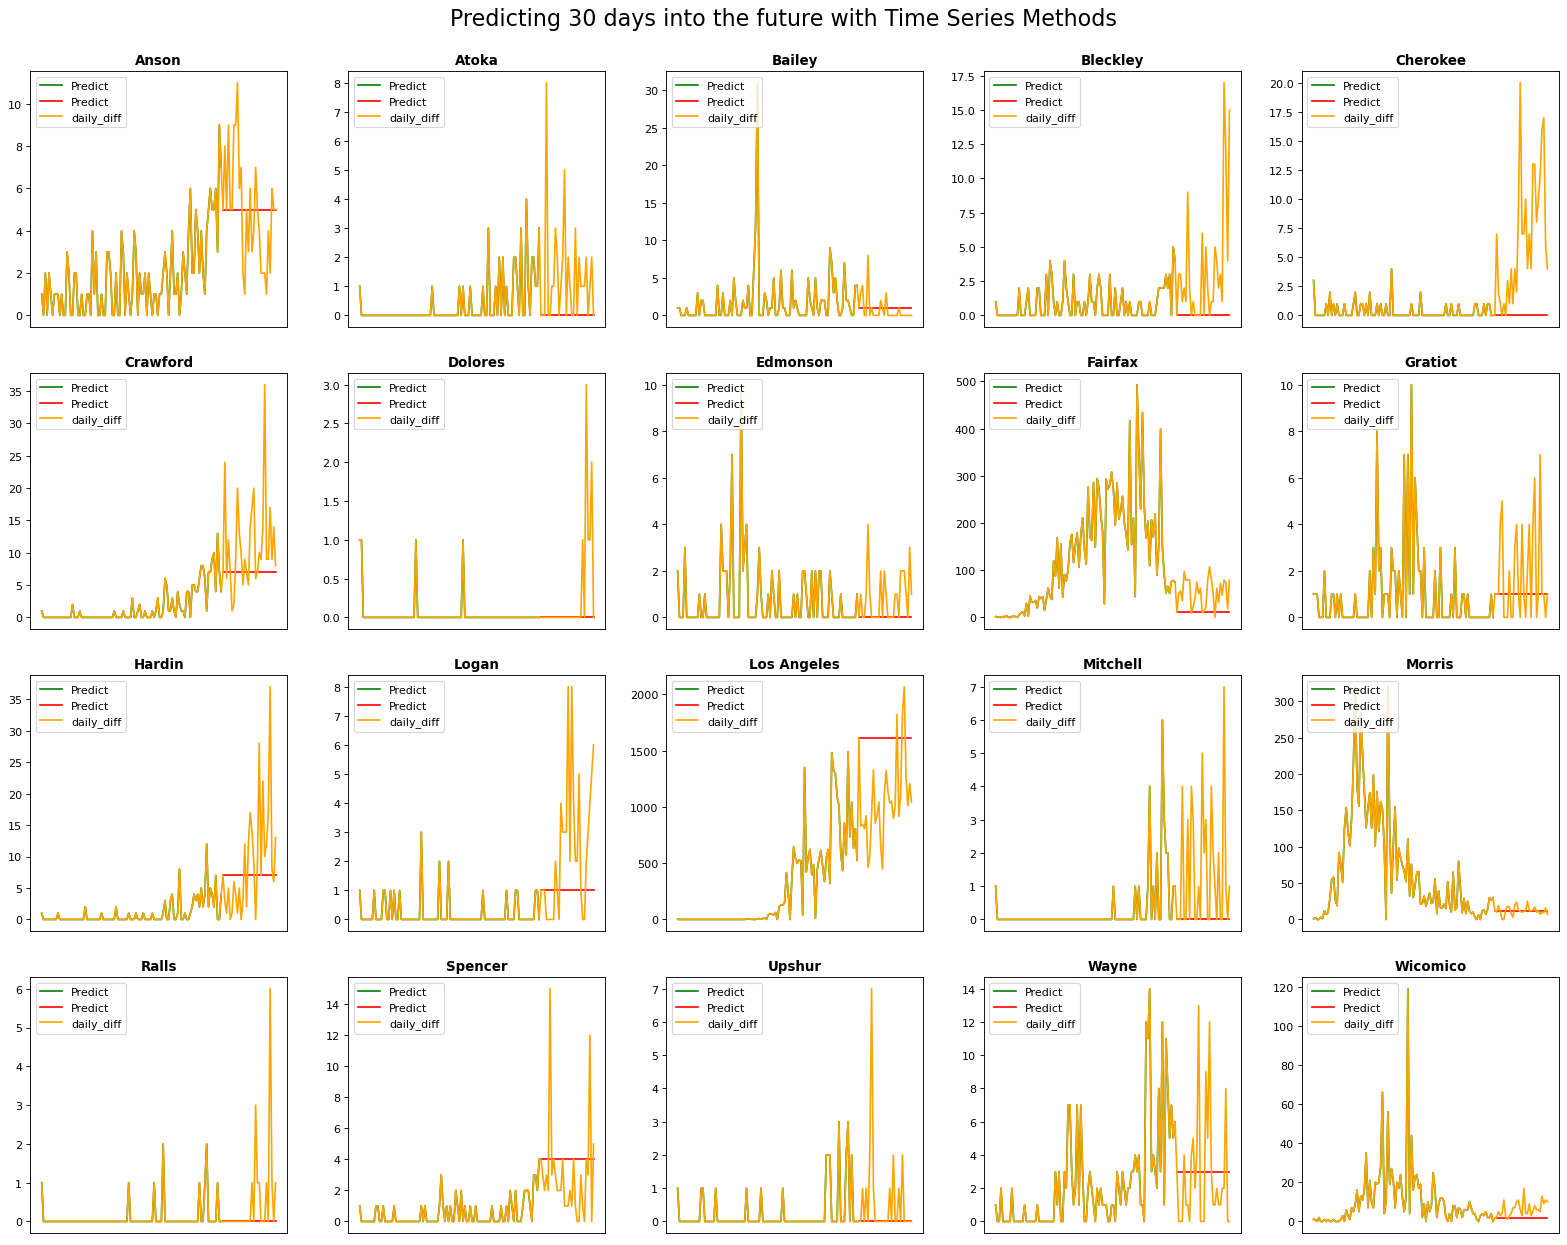

In [169]:
def plot_series(dct):
    
    index = 1
    fig = figure(figsize=(20, 16), dpi=80)
    cols_to_plot = ["Expected_Theory","daily_cases"]
        
    for c, data in dct.items():
        
        df = data
        ax = fig.add_subplot(4,5,index)
        index += 1

        fig.suptitle("Predicting 30 days into the future with Time Series Methods",fontsize=20)
        #df[df.columns.intersection(cols_to_plot)].plot(ax=ax)
        df.loc[df.index < 100,"Predict"].plot(ax=ax,c="green")
        df.loc[df.index >= 100,"Predict"].plot(ax=ax,c="red")
        df.loc[:,"daily_diff"].plot(ax=ax,c="orange")
        plt.title(c,fontsize="large",fontweight="bold")
        plt.legend(loc="upper left")
        plt.xticks([])
        plt.xlabel("")
    plt.tight_layout(pad=2.2)

plot_series(time_out_naive)

In [176]:

def calc_new(dct):
    #store RMSE for df
    rmse = {}
    
    #create df with cols being RMSE for each model type and rows are the county
    
    for c, value in dct.items():
        
        rmse[c] = np.sqrt(sum(value.tail(30).Sq_Er))
    
    return(rmse)
    

mean_rmse = calc_new(time_out_mean)
naive_rmse = calc_new(time_out_naive)
drift_rmse = calc_new(time_out_drift)

mean_rmse = pd.DataFrame.from_dict(mean_rmse,orient="index")
naive_rmse = pd.DataFrame.from_dict(naive_rmse,orient="index")
drift_rmse = pd.DataFrame.from_dict(drift_rmse,orient="index")

allmethods_rmse = all_rmse.join(mean_rmse.join(naive_rmse.join(drift_rmse,rsuffix="Drift"),rsuffix="Naive"),rsuffix="Mean")
allmethods_rmse.columns = ["nth_rmse","MLE_rmse","seven_rmse","Mean_RMSE","Naive_RMSE","Drift_RMSE"]

def highlight_min(x, color):
    return np.where(x == np.nanmin(x.to_numpy()), f"color: {color};", None)
allmethods_rmse.style.apply(highlight_min,color="green",axis=1)

,nth_rmse,MLE_rmse,seven_rmse,Mean_RMSE,Naive_RMSE,Drift_RMSE
Anson,18.164562,22.092220,21.807663,22.139828,13.856406,369.380563
Atoka,11.789826,10.804891,9.427676,10.688639,11.789826,103.556748
Bailey,9.380832,11.479057,11.130030,10.835266,9.380832,10.295630
Bleckley,30.248967,27.604929,23.493957,27.445072,30.099834,120.569482
Cherokee,46.270941,45.051350,44.708820,44.424937,45.880279,332.258935
Crawford,39.658073,66.226406,38.257778,65.004615,44.609416,528.151493
Dolores,4.000000,3.966754,4.000000,3.925303,4.000000,99.503769
Edmonson,7.348469,5.682933,6.990172,5.685772,7.280110,199.150697
Fairfax,257.452194,1426.873389,411.677448,457.860669,277.151583,651.369327
Gratiot,11.747340,11.794476,13.855355,11.788639,11.747340,14.696938
